# Tree Embeddings (Dyck vs. Full Binary)

2D Euclidean embeddings via SMACOF for two extremes of tree structure:
- A single sampled Dyck tree per depth (1–6).
- Complete binary trees per depth.

Metrics: Pearson correlation and MSE between true and reconstructed distances. Embeddings colored by node depth.

In [ ]:
import math
import random
from collections import defaultdict
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import smacof
from sklearn.metrics import pairwise_distances

sns.set_context("talk")
plt.rcParams["figure.figsize"] = (8, 6)

def _parse_range(values, name: str, min_value: int = 1) -> tuple[int, int]:
    if isinstance(values, (int, float)):
        values = [int(values)]
    if len(values) == 1:
        range_min = range_max = int(values[0])
    elif len(values) == 2:
        range_min, range_max = [int(v) for v in values]
    else:
        raise ValueError(f"{name} must have 1 or 2 integers")
    if range_min < min_value or range_max < min_value or range_max < range_min:
        raise ValueError(f"{name} must be >= {min_value} and max >= min")
    return range_min, range_max

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
DEPTH_RANGE = [1, 6]
MIN_DEPTH, MAX_DEPTH = _parse_range(DEPTH_RANGE, "depth-range", min_value=1)
DEPTHS = list(range(MIN_DEPTH, MAX_DEPTH + 1))


In [ ]:
def random_dyck_sequence(target_depth: int, max_len: int = 400) -> List[int]:
    seq: List[int] = []
    stack: List[int] = []
    max_seen = 0
    for _ in range(target_depth):
        seq.append(1); stack.append(1); max_seen = max(max_seen, len(stack))
    while stack and len(seq) < max_len:
        close_prob = 0.6 if len(stack) >= 1 else 0.3
        if len(stack) == target_depth or random.random() < close_prob:
            seq.append(2); stack.pop()
        else:
            seq.append(1); stack.append(1); max_seen = max(max_seen, len(stack))
    while stack and len(seq) < max_len:
        seq.append(2); stack.pop()
    if max_seen != target_depth or stack:
        return []
    return seq


def build_dyck_parent(sequence: List[int]) -> Dict[int, int]:
    parent: Dict[int, int] = {}
    stack: List[int] = []
    for pos, tok in enumerate(sequence):
        if tok % 2 == 1:
            parent[pos] = stack[-1] if stack else -1
            stack.append(pos)
        else:
            if stack:
                parent[pos] = stack[-1]; stack.pop()
            else:
                parent[pos] = -1
    return parent


def parent_to_depths_and_dist(parent: Dict[int, int]) -> Tuple[np.ndarray, np.ndarray]:
    n = len(parent)
    depth_cache = {-1: 0}
    def depth(node: int) -> int:
        if node in depth_cache: return depth_cache[node]
        d = 1 + depth(parent.get(node, -1)); depth_cache[node] = d; return d
    depths = np.array([depth(i) for i in range(n)], dtype=np.int32)
    root = n
    adj = [[] for _ in range(n + 1)]
    for i, p in parent.items():
        if p == -1:
            adj[i].append(root); adj[root].append(i)
        else:
            adj[i].append(p); adj[p].append(i)
    from collections import deque
    dist = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        q = deque([i]); seen = {i}; dmap = {i: 0}
        while q:
            u = q.popleft()
            for v in adj[u]:
                if v == root: continue
                if v not in seen:
                    seen.add(v); dmap[v] = dmap[u] + 1; q.append(v)
        for j, d in dmap.items():
            dist[i, j] = dist[j, i] = d
    return depths, dist


def build_full_binary(depth: int) -> Tuple[np.ndarray, np.ndarray]:
    n = (1 << (depth + 1)) - 1
    depths = np.zeros(n, dtype=np.int32)
    for i in range(n):
        depths[i] = int(math.floor(math.log2(i + 1)))
    dist = np.zeros((n, n), dtype=np.float32)
    def lca(a: int, b: int) -> int:
        da, db = depths[a], depths[b]
        u, v = a, b
        while da > db:
            u = (u - 1) // 2; da -= 1
        while db > da:
            v = (v - 1) // 2; db -= 1
        while u != v:
            u = (u - 1) // 2; v = (v - 1) // 2
        return u
    for i in range(n):
        for j in range(i + 1, n):
            l = lca(i, j)
            d = depths[i] + depths[j] - 2 * depths[l]
            dist[i, j] = dist[j, i] = d
    return depths, dist

In [ ]:
def embed_smacof(D: np.ndarray, dim: int = 2, seed: int = SEED) -> Tuple[np.ndarray, float]:
    coords, stress = smacof(D, n_components=dim, random_state=seed, verbose=0, max_iter=500)
    return coords.astype(np.float32), stress


def metrics(D_true: np.ndarray, coords: np.ndarray) -> Tuple[float, float]:
    D_hat = pairwise_distances(coords)
    tri = np.triu_indices_from(D_true, k=1)
    true_vals = D_true[tri]; pred_vals = D_hat[tri]
    if np.std(true_vals) < 1e-8 or np.std(pred_vals) < 1e-8:
        corr = np.nan
    else:
        corr = np.corrcoef(true_vals, pred_vals)[0, 1]
    mse = float(np.mean((true_vals - pred_vals) ** 2))
    return corr, mse

In [ ]:
records = []
embeddings = []
for depth in DEPTHS:
    # Dyck: one sample hitting target depth
    dyck_seq = []
    attempts = 0
    while not dyck_seq and attempts < 200:
        dyck_seq = random_dyck_sequence(target_depth=depth)
        attempts += 1
    if dyck_seq:
        p = build_dyck_parent(dyck_seq)
        dyck_depths, dyck_dist = parent_to_depths_and_dist(p)
        coords, _ = embed_smacof(dyck_dist, dim=2)
        corr, mse = metrics(dyck_dist, coords)
        records.append({"type": "dyck", "depth": depth, "nodes": len(dyck_seq), "pearson": corr, "mse": mse})
        embeddings.append({"type": "dyck", "depth": depth, "coords": coords, "node_depths": dyck_depths})
    else:
        records.append({"type": "dyck", "depth": depth, "nodes": 0, "pearson": np.nan, "mse": np.nan})
    # Binary
    bin_depths, bin_dist = build_full_binary(depth)
    coords, _ = embed_smacof(bin_dist, dim=2)
    corr, mse = metrics(bin_dist, coords)
    records.append({"type": "binary", "depth": depth, "nodes": len(bin_depths), "pearson": corr, "mse": mse})
    embeddings.append({"type": "binary", "depth": depth, "coords": coords, "node_depths": bin_depths})

metrics_df = pd.DataFrame(records)
metrics_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value o

,type,depth,nodes,pearson,mse
0,dyck,1,2,NaN,0.000000
1,binary,1,3,1.000000,0.000012
2,dyck,2,6,0.996843,0.011165
3,binary,2,7,0.991607,0.023337
4,dyck,3,6,0.996557,0.010991
5,binary,3,15,0.962960,0.194760
6,dyck,4,14,0.853385,0.390594
7,binary,4,31,0.924734,0.780355
8,dyck,5,10,0.974823,0.085946
9,binary,5,63,0.890101,1.998425


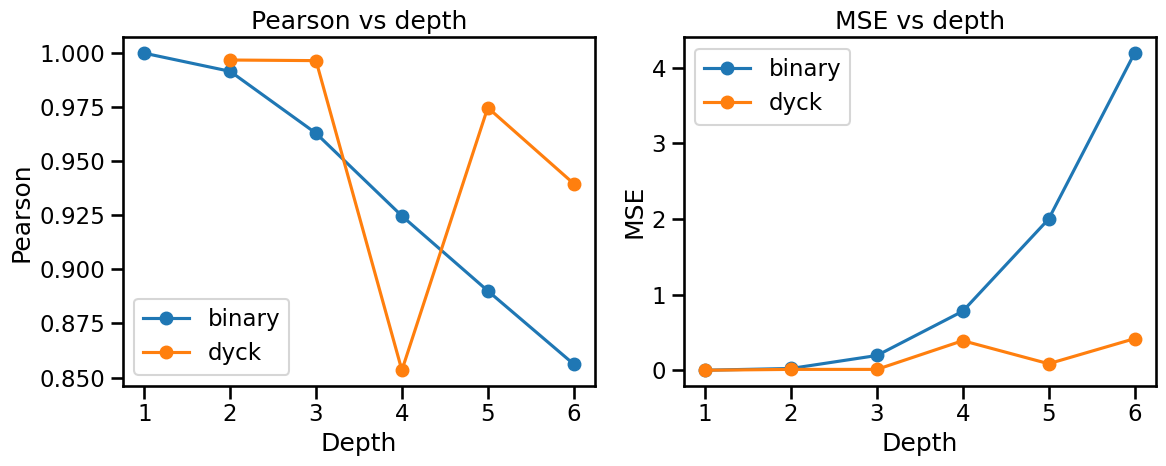

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for t, df in metrics_df.groupby('type'):
    axes[0].plot(df['depth'], df['pearson'], marker='o', label=t)
    axes[1].plot(df['depth'], df['mse'], marker='o', label=t)
axes[0].set_title('Pearson vs depth'); axes[0].set_xlabel('Depth'); axes[0].set_ylabel('Pearson')
axes[1].set_title('MSE vs depth'); axes[1].set_xlabel('Depth'); axes[1].set_ylabel('MSE')
axes[0].legend(); axes[1].legend();
plt.tight_layout(); plt.show()

/var/folders/s1/tvdnvl8n0l52wc16d3x78qlw0000gn/T/ipykernel_93908/1548969431.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.89, 1])  # leave new space for colorbar explicitly


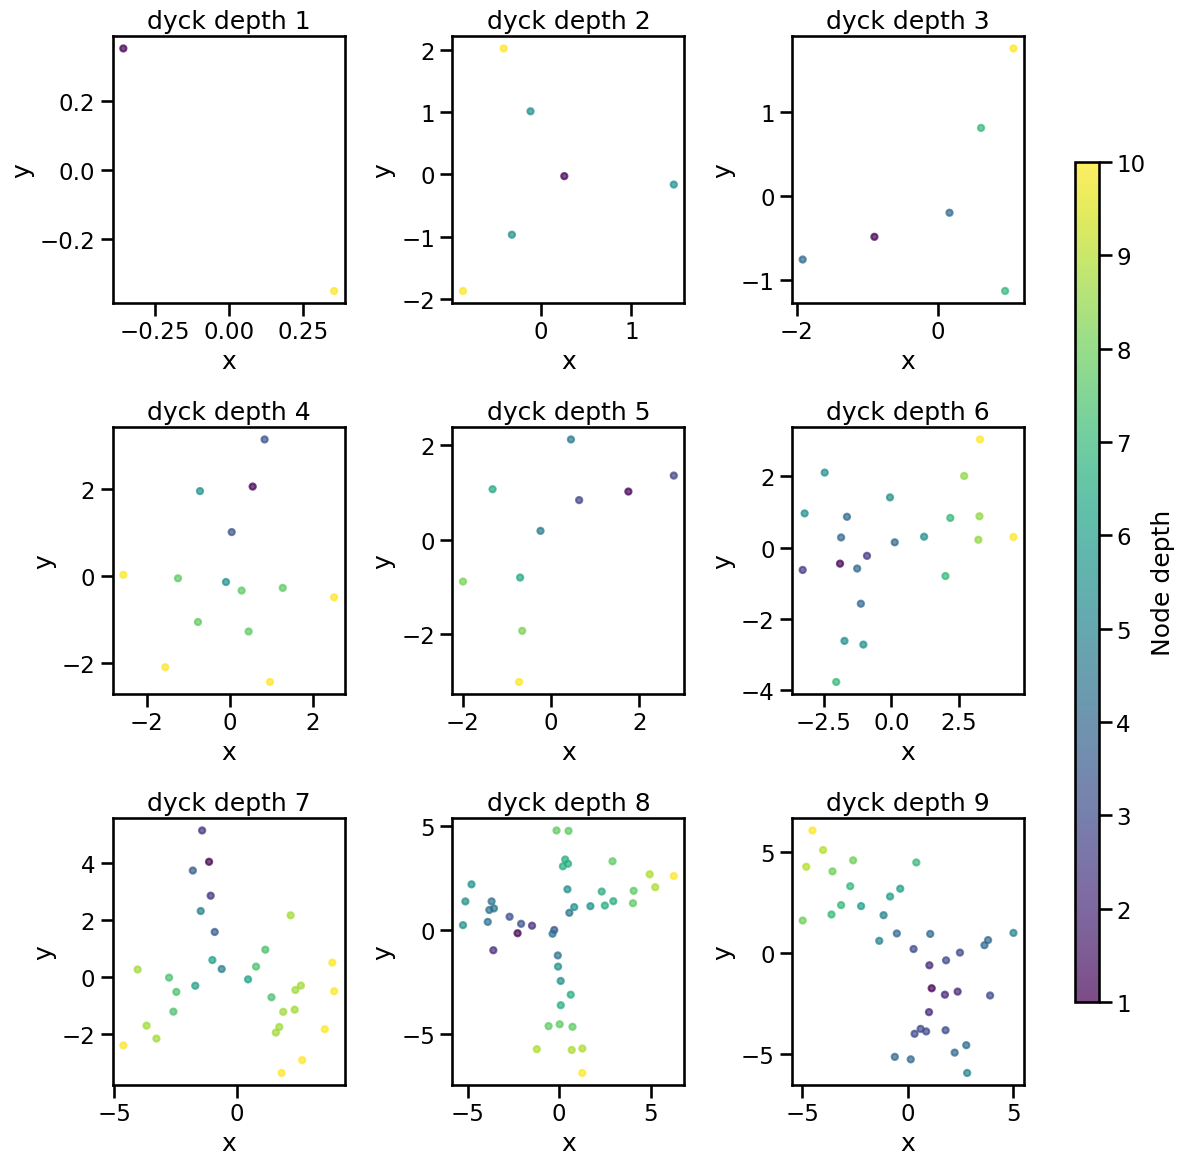

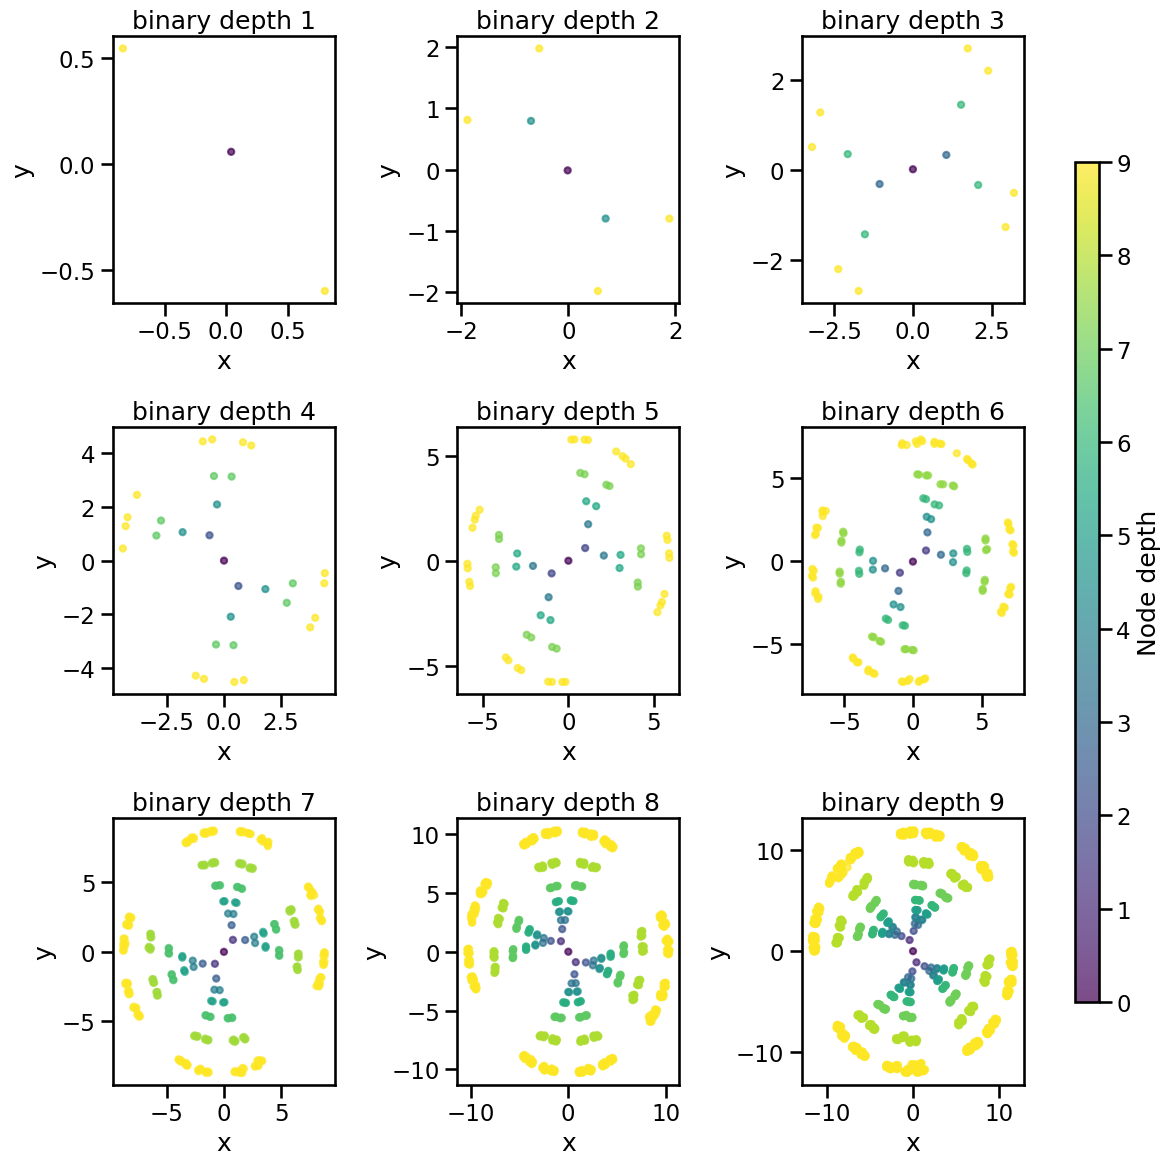

In [ ]:
# Embeddings colored by node depth
import math

for t in ['dyck', 'binary']:
    subset = [e for e in embeddings if e['type'] == t]
    n = len(subset)
    if n == 0:
        continue
    # Arrange subplots as close to a square as possible
    ncols = math.ceil(math.sqrt(n))
    nrows = math.ceil(n / ncols)
    fig_width = 4 * ncols
    fig_height = 4 * nrows

    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), squeeze=False)
    axes_flat = axes.ravel()
    sc = None  # For colorbar
    for i, (ax, emb) in enumerate(zip(axes_flat, subset)):
        sc = ax.scatter(
            emb['coords'][:, 0], emb['coords'][:, 1], 
            c=emb['node_depths'], cmap='viridis', s=20, alpha=0.7
        )
        ax.set_title(f"{t} depth {emb['depth']}")
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    # Hide any unused subplots
    for j in range(i+1, len(axes_flat)):
        axes_flat[j].set_visible(False)

    # --- Arrange for colorbar to be in its own figure row at right ---
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Use the last axis for colorbar placement (right side)
    divider = make_axes_locatable(axes_flat[0])
    # Create a new axis for colorbar just outside the rightmost axes
    fig.subplots_adjust(right=0.88)  # Adjust right side to make space for colorbar
    # Place colorbar at [left, bottom, width, height] in figure coordinates
    cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(sc, cax=cbar_ax, label='Node depth')
    plt.tight_layout(rect=[0, 0, 0.89, 1])  # leave new space for colorbar explicitly
    plt.show()